In [1]:
import mga
import ctrnn_leg
import leggedwalker
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Parameters #
# NN parameters 
WR = 16
BR = 16
TMIN = 0.5
TMAX = 10.0

# Simulation Parameters
duration = 100.0 #220
stepsize = 0.1
time = np.arange(0.0,duration,stepsize)

# # Noise Parameters
# noiseMax = 0.3 
# noiseStep = 0.01 
# repn = 100
# noiseRange = np.arange(0,noiseMax,noiseStep)

# Curve Fitting 
def quad(x, a, b, c):
    ''' quadratic function '''
    return a*(x**2) + b*x + c

def curveFit(x, y): 
    ''' fits a quadratic function to data, y '''
    constants = curve_fit(quad, x, y)
    a_fit = constants[0][0]
    b_fit = constants[0][1]
    c_fit = constants[0][2]

    fitted = []
    for i in x: 
        fitted.append(quad(i, a_fit, b_fit, c_fit))
    
    plt.plot(x, fitted, label = str(format(a_fit, ".3f"))+ "x^2 + " + str(format(b_fit, ".3f"))+ "x + " + str(format(c_fit, ".3f")))
    
    return a_fit, b_fit, c_fit


In [3]:
# Neural Paramteric Robustness Analysis #

# Analysis 
def nParam(genotype, N): 
    ''' takes in genotype and number of neurons in NN to output a degradation graph and robustness measure'''
    print("\nstarting analysis")
    
    #Local Parameters 
    geneArray = np.zeros((repn, len(genotype)))  # Stores all noisy genotypes
    fit = []                                     # Stores all fitness values 
    avArray = np.zeros((len(noiseRange)))        # Stores average fitness values for each noise level
    seArray = np.zeros ((len(noiseRange)))       # Stores standard error of fitness values for each noise level
    
    counter = 0
    
    # Gaussian Noise 
    for noise in noiseRange: 
        for r in range(repn):  
            v = np.random.normal(0.0,1.0,size = len(genotype)) # creates random vector 
            nv = np.sqrt(np.sum(v**2))                         # v/nv = normalized random vector 
            geneArray[r] = genotype + noise * (v/nv)           # adds normalized noise value to genotype
            
        for g in geneArray: 
            ns = ctrnn_leg.CTRNN(N)
            ns.setParameters(g,WR,BR,TMIN,TMAX)
            body = leggedwalker.LeggedAgent()
            
            #Simulation
            for t in time:
                ns.step(stepsize,body.out())
                body.step3(stepsize,ns.out3())
            
            fit += [body.cx/duration]
            
        print(len(noiseRange)-counter, "iterations left")
        counter += 1
    
    fitArray = np.array(fit)                                # Converts list fit into array 
    fitArray = fitArray.reshape((len(noiseRange), repn))    # Reshapes fitArray for usability
    for f in range(len(fitArray)):
        avArray[f] = np.nanmean(fitArray[f])
        seArray[f] = np.nanstd(fitArray[f])/np.sqrt(len(fitArray[f]))
    
    #Plot
    plt.errorbar(noiseRange, avArray, yerr = seArray, label = "degradation")
    a, b, c = curveFit(noiseRange, avArray)
    
    plt.xlabel("noise")
    plt.ylabel("fitness")
    plt.title("Neural Parametric Degradation")
    plt.legend()
    plt.show()
    
    print("Robustness Measure = ", a)
    


In [11]:
# Neural State Robustness Analysis #  
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def nState_1(genotype, N): #Noise to input
    '''  takes in genotype and number of neurons in NN to output a degradation graph and robustness measure'''
    print("\n starting analysis")

    #Local Parameters 
    fit = []                                     # Stores all fitness values 
    avArray = np.zeros((len(noiseRange)))        # Stores average fitness values for each noise level
    seArray = np.zeros ((len(noiseRange)))       # Stores standard error of fitness values for each noise level
    
    # Create System #
    ns = ctrnn_leg.CTRNN(N)
    ns.setParameters(genotype,WR,BR,TMIN,TMAX)
    body = leggedwalker.LeggedAgent()
    
    counter = 0
    
    # Noise level iteration
    for noise in noiseRange: 
        
        # Repetition iteration
        for r in range(repn):  
            
            #Innitialize neural state and body state 
            ns.initializeState(np.zeros(N))
            body.initializeState()
            
            # Simulation
            for t in time:
                v = np.random.normal(0.0,1.0,size = N) # creates random vector 
                nv = np.sqrt(np.sum(v**2))             # v/nv = normalized random vector 
                ns.Input = noise * (v/nv)
                ns.Input += body.out()
                netinput = ns.Input + np.dot(ns.Weights.T, ns.Output)
                ns.Voltage += stepsize * (ns.invTimeConstant*(-ns.Voltage+netinput)) 
                ns.Output = sigmoid(ns.Voltage+ns.Bias)

                body.step3(stepsize,ns.out3())
            
            fit += [body.cx/duration]
        
        print(len(noiseRange)-counter, "iterations left")
        counter += 1
    
    fitArray = np.array(fit)                                # Converts list fit into array 
    fitArray = fitArray.reshape((len(noiseRange), repn))    # Reshapes fitArray for usability
    for f in range(len(fitArray)):
        avArray[f] = np.nanmean(fitArray[f])
        seArray[f] = np.nanstd(fitArray[f])/np.sqrt(len(fitArray[f]))
    
    #Plot
    plt.errorbar(noiseRange, avArray, yerr = seArray, label = "degradation")
    a, b, c = curveFit(noiseRange, avArray)
    
    plt.xlabel("noise to Neuron States")
    plt.ylabel("fitness")
    plt.title("Neural State Degradation: Input")
    plt.legend()
    plt.show()
    
    print("Robustness Measure = ", a)


    
    
def nState_2(genotype, N): #Noise to voltage
    '''  takes in genotype and number of neurons in NN to output a degradation graph and robustness measure'''
    print("\n starting analysis")

    #Local Parameters 
    fit = []                                     # Stores all fitness values 
    avArray = np.zeros((len(noiseRange)))        # Stores average fitness values for each noise level
    seArray = np.zeros ((len(noiseRange)))       # Stores standard error of fitness values for each noise level
    
    # Create System #
    ns = ctrnn_leg.CTRNN(N)
    ns.setParameters(genotype,WR,BR,TMIN,TMAX)
    body = leggedwalker.LeggedAgent()
    
    counter = 0
    
    # Noise level iteration
    for noise in noiseRange: 
        
        # Repetition iteration
        for r in range(repn):  
            
            #Innitialize neural state and body state 
            ns.initializeState(np.zeros(N))
            body.initializeState()
            ns.Voltage = np.random.normal(noise, 0.1, size = N)
            
            # Simulation
            for t in time:
                ns.Input = body.out()
                netinput = ns.Input + np.dot(ns.Weights.T, ns.Output)
                ns.Voltage += stepsize * (ns.invTimeConstant*(-ns.Voltage+netinput)) 
                ns.Output = sigmoid(ns.Voltage+ns.Bias)

                body.step3(stepsize,ns.out3())
            
            fit += [body.cx/duration]
        
        print(len(noiseRange)-counter, "iterations left")
        counter += 1
    
    fitArray = np.array(fit)                                # Converts list fit into array 
    fitArray = fitArray.reshape((len(noiseRange), repn))    # Reshapes fitArray for usability
    for f in range(len(fitArray)):
        avArray[f] = np.nanmean(fitArray[f])
        seArray[f] = np.nanstd(fitArray[f])/np.sqrt(len(fitArray[f]))
    
    #Plot
    plt.errorbar(noiseRange, avArray, yerr = seArray, label = "degradation")
    # a, b, c = curveFit(noiseRange, avArray)
    
    plt.xlabel("noise")
    plt.ylabel("fitness")
    plt.title("Neural State Degradation: Voltage")
    plt.legend()
    plt.show()
    
    # print("Robustness Measure = ", a)




 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


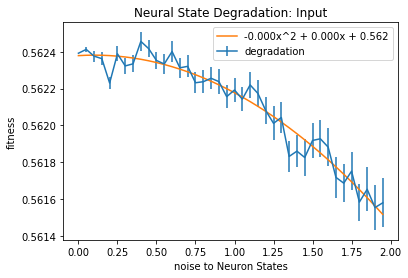

Robustness Measure =  -0.00025309708885820376

 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


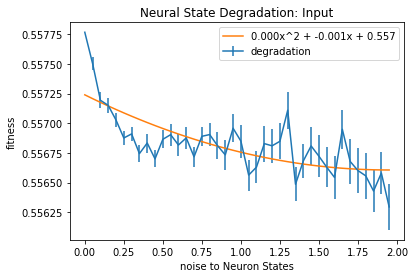

Robustness Measure =  0.0001672100012192814

 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


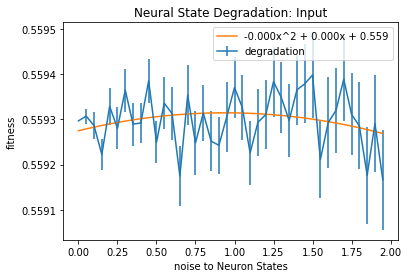

Robustness Measure =  -4.480622358233219e-05

 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


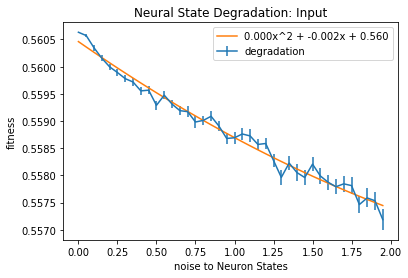

Robustness Measure =  0.00023133109402832293

 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


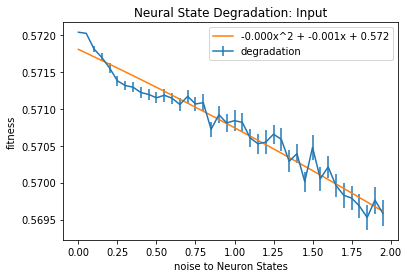

Robustness Measure =  -6.695152108364699e-05


In [15]:
# Noise Parameters
noiseMax = 2 
noiseStep = 0.05 
repn = 100
noiseRange = np.arange(0,noiseMax,noiseStep)  


# Testing #
bestfitArray = np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestfitArray")
# genotype = list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")).pop(np.argmax(bestfitArray[2]))
for i in list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")):
    nState_1(i, 3)



 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


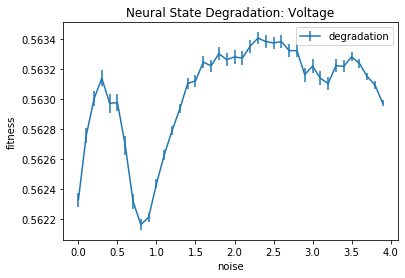


 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


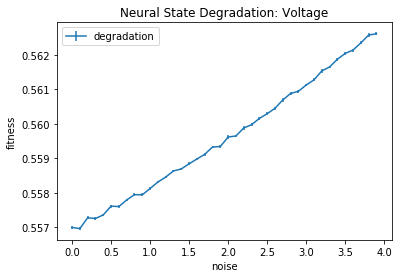


 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


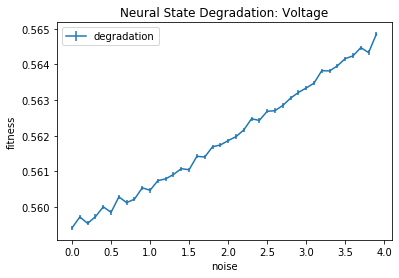


 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


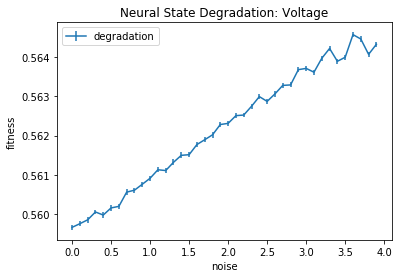


 starting analysis
40 iterations left
39 iterations left
38 iterations left
37 iterations left
36 iterations left
35 iterations left
34 iterations left
33 iterations left
32 iterations left
31 iterations left
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


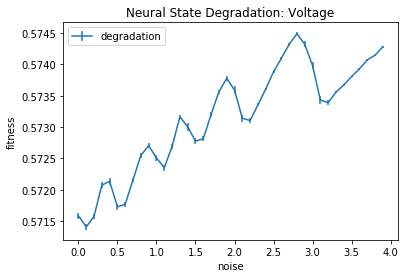

In [13]:
# Noise Parameters
noiseMax = 10 
noiseStep = 0.05 
repn = 100
noiseRange = np.arange(0,noiseMax,noiseStep)   
    

# Testing #
bestfitArray = np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestfitArray")
# genotype = list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")).pop(np.argmax(bestfitArray[2]))
for i in list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")):
    nState_2(i, 3)

In [26]:
# Body/Env Paramteric Robustness Analysis #

def eParam(genotype, N): 
    ''' takes in genotype and number of neurons in NN to output a degradation graph and robustness measure'''
    print("\nstarting analysis")
    
    #Local Parameters 
    fit = []                                     # Stores all fitness values 
    avArray = np.zeros((len(noiseRange)))        # Stores average fitness values for each noise level
    seArray = np.zeros ((len(noiseRange)))       # Stores standard error of fitness values for each noise level 
    
    counter = 0
    
    # Create System
    ns = ctrnn_leg.CTRNN(N)
    ns.setParameters(genotype,WR,BR,TMIN,TMAX)
    body = leggedwalker.LeggedAgent()
    
    #Noise level iteration
    for noise in noiseRange: 
        
        #Repetition iteration
        for r in range(repn):
            
            #Innitialize neural state and body state 
            ns.initializeState(np.zeros(N))
            body.initializeState()
            body.LegLength += np.random.normal(noise, 0.1)
            
            # Time Simulation
            for t in time:
                ns.step(stepsize,body.out())
                body.step3(stepsize,ns.out3())
    
            fit += [body.cx/duration]

            
        print(len(noiseRange)-counter, "iterations left")
        counter += 1
    
    fitArray = np.array(fit)                                # Converts list fit into array 
    fitArray = fitArray.reshape((len(noiseRange), repn))    # Reshapes fitArray for usability
    for f in range(len(fitArray)):
        avArray[f] = np.nanmean(fitArray[f])
        seArray[f] = np.nanstd(fitArray[f])/np.sqrt(len(fitArray[f]))
    
    #Plot
    plt.errorbar(noiseRange, avArray, yerr = seArray, label = "degradation")
    a, b, c = curveFit(noiseRange, avArray)
    
    plt.xlabel("Noise to Leg Length")
    plt.ylabel("fitness")
    plt.title("Env. Parametric Degradation")
    plt.legend()
    plt.show()
    
    print("Robustness Measure = ", a)
    


starting analysis
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


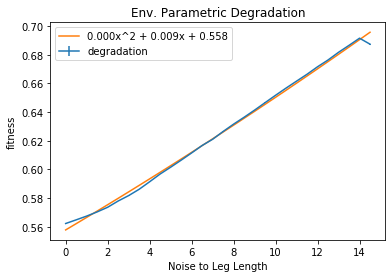

Robustness Measure =  5.798104903972466e-05

starting analysis
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


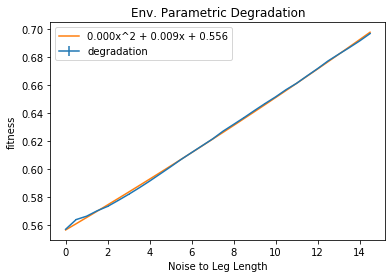

Robustness Measure =  6.344470106580254e-05

starting analysis
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


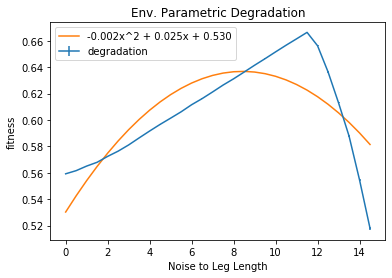

Robustness Measure =  -0.0015018432217932531

starting analysis
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


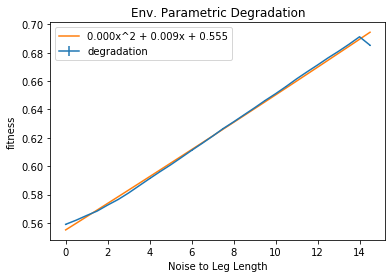

Robustness Measure =  2.063270176544396e-05

starting analysis
30 iterations left
29 iterations left
28 iterations left
27 iterations left
26 iterations left
25 iterations left
24 iterations left
23 iterations left
22 iterations left
21 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


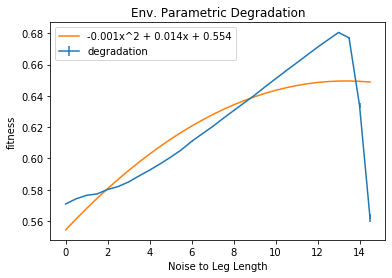

Robustness Measure =  -0.0005344067066475056


In [27]:

# Noise Parameters
noiseMax = 15 
noiseStep = 0.5
repn = 100
noiseRange = np.arange(0,noiseMax,noiseStep)

# Testing #
bestfitArray = np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestfitArray")
# genotype = list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")).pop(np.argmax(bestfitArray[2]))
for i in list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")):
    eParam(i, 3)


In [28]:
# Body/Env State Robustness Analysis #



def eState(genotype, N): 
    ''' takes in genotype and number of neurons in NN to output a degradation graph and robustness measure'''
    print("\nstarting analysis")
    
    #Local Parameters 
    fit = []                                     # Stores all fitness values 
    avArray = np.zeros((len(noiseRange)))        # Stores average fitness values for each noise level
    seArray = np.zeros ((len(noiseRange)))       # Stores standard error of fitness values for each noise level
    
    counter = 0
    
    # Create System
    ns = ctrnn_leg.CTRNN(N)
    ns.setParameters(genotype,WR,BR,TMIN,TMAX)
    body = leggedwalker.LeggedAgent()
    
    #Noise level iteration
    for noise in noiseRange: 
        
        #Repetition iteration
        for r in range(repn):
            
            #Innitialize neural state and body state 
            ns.initializeState(np.zeros(N))
            body.initializeState()
            
            
            # Time Simulation
            for t in time: 
                rnNoise = np.random.normal(noise, 0.1)
                ns.step(stepsize,body.out())
                body.angle += rnNoise
                body.omega += rnNoise   
                body.step3(stepsize,ns.out3())
    
            fit += [body.cx/duration]
            
        print(len(noiseRange)-counter, "iterations left")
        counter += 1
    
    fitArray = np.array(fit)                                # Converts list fit into array 
    fitArray = fitArray.reshape((len(noiseRange), repn))    # Reshapes fitArray for usability
    for f in range(len(fitArray)):
        avArray[f] = np.nanmean(fitArray[f])
        seArray[f] = np.nanstd(fitArray[f])/np.sqrt(len(fitArray[f]))
    
    #Plot
    plt.errorbar(noiseRange, avArray, yerr = seArray, label = "degradation")
    #a, b, c = curveFit(noiseRange, avArray)
    
    plt.xlabel("noise to body constants")
    plt.ylabel("fitness")
    plt.title("Env State Degradation")
    plt.legend()
    plt.show()

    #print("Robustness Measure = ", a)


starting analysis
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


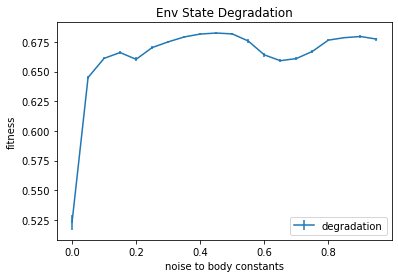


starting analysis
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


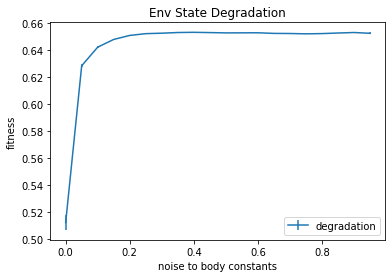


starting analysis
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


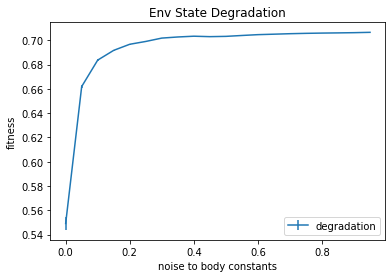


starting analysis
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


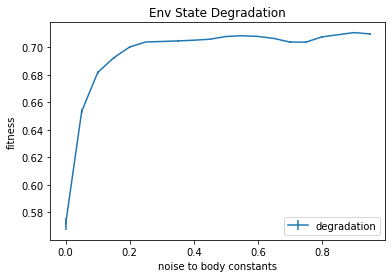


starting analysis
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


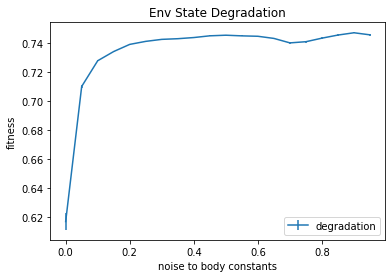

In [29]:
# Noise Parameters
noiseMax = 1 
noiseStep = 0.05 
repn = 100
noiseRange = np.arange(0,noiseMax,noiseStep)  


# Testing #
bestfitArray = np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestfitArray")
# genotype = list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")).pop(np.argmax(bestfitArray[2]))
for i in list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")):
    eState(i, 3)


In [ ]:
# Testing #
bestfitArray = np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestfitArray")
genotype = list(np.loadtxt("/Users/JoshetaaMacbookPro/Desktop/Evolutionaty Robotics/N_Param_Rob_Data/Evolved RPGs/bestInd3")).pop(np.argmax(bestfitArray[1]))
# nParam(genotype, 3)
# nState_1(genotype, 3)
# nState_2(genotype, 3)
# eParam(genotype, 3)
# eState(genotype, 3)
    
    
    